**<div align="center"><span style="font-size:4em">Exercise</span></div>**

# Mushrooms

In this notebook you're expected to practice setting up and training a simple neural network with tensorflow. If you're running this in Colab then you will not need to install any packages. If you run this on your own compute, you may need to install tensorflow, scikit-learn, numpy or matplotlib.

First we do the necessary imports.

In [148]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("seaborn-v0_8")
print("Tensorflow version: "+tf.version.VERSION)

import sklearn.datasets
import sklearn.preprocessing
import sklearn.utils

Tensorflow version: 2.15.0


Next we download a simple dataset on mushrooms. The task will consist in predicting whether a given mushroom is edible or poisonous. The dataset itself is hosted on a repository for a number of datasets used in machine learning: [openml](https://www.openml.org/) To download the data, we use a convenient method of scikit-learn (and that is also the reason why we're import scikit-learn at all).

In [149]:
data,target=sklearn.datasets.fetch_openml('mushroom',return_X_y=True)

c:\Users\lauri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\datasets\_openml.py:311: UserWarning: Multiple active versions of the dataset matching the name mushroom exist. Versions may be fundamentally different, returning version 1.
  warn(
c:\Users\lauri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Okay, a warning that in the future something will change. That shouldn't bother us. Let's look at the data.

In [150]:
data

,cap-shape,cap-surface,cap-color,bruises%3F,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,k,s,n,f,n,a,c,b,y,e,...,s,o,o,p,o,o,p,b,c,l
8120,x,s,n,f,n,a,c,b,y,e,...,s,o,o,p,n,o,p,b,v,l
8121,f,s,n,f,n,a,c,b,n,e,...,s,o,o,p,o,o,p,b,c,l
8122,k,y,n,f,y,f,c,n,b,t,...,k,w,w,p,w,o,e,w,v,l


Okay, apparently each mushroom is described by a number of characteristics that will be familiar to every mushroom lover. What matters for us: the features are not encoded numerically -- we'll need to change that. But first let's look at the target.

In [151]:
target

0       p
1       e
2       e
3       p
4       e
       ..
8119    e
8120    e
8121    e
8122    p
8123    e
Name: class, Length: 8124, dtype: category
Categories (2, object): ['e', 'p']

Aha, two values 'e' (as in *edible*) and 'p' (as in *rather not*). Also here: we'll need to change that to a numerical value. Let's start with the target. We simply put a '1' whenever the mushroom in question is poisonous. The code looks a bit more complicated because I want to the target to be encoded as a *float* vector, ie, with values 1.0 and 0.0. (If we don't specify that we'll get a vector of <code>True</code> and <code>False</code> values.)

In [152]:
yy=np.array(target=='p',dtype='float')

Next, let's transform the data. *scikit-learn* provides a convenient class to do that, the <code>OneHotEncoder</code>. *tensorflow* offers similar functionality but it's a little bit more complicated to use so we'll go with *scikit-learn*. Let's look at a small toy example to figure out how that works.

In [153]:
sample_data=[['cat','light saber'],['dog','stick'],['rat','light saber']]

one_hot_encoder=sklearn.preprocessing.OneHotEncoder(sparse_output=False)
one_hot_encoder.fit_transform(sample_data)

array([[1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0.]])

The first three entries in each row encode *cat*, *dog*, *rat*, the last two encode *light saber* and *stick*.

Let's now apply that to the mushroom data.

In [154]:
one_hot_encoder=sklearn.preprocessing.OneHotEncoder(sparse_output=False)
XX=one_hot_encoder.fit_transform(data)

Let's check how the data has changed. Before we had (compare the table above) 8124 datapoints with 22 features.

In [155]:
XX.shape

(8124, 117)

We split the data into three sets: A training set, a test set and a validation set that we will use to estimate the final error during training.

In [156]:
X,y=sklearn.utils.shuffle(XX,yy) # let's make sure the data is in random order
train_size=6000
val_size=1000
X_train,X_val,X_test=X[:train_size],X[train_size:train_size+val_size],X[train_size+val_size:]
y_train,y_val,y_test=y[:train_size],y[train_size:train_size+val_size],y[train_size+val_size:]
X_train.shape,X_val.shape,X_test.shape

((6000, 117), (1000, 117), (1124, 117))

In [157]:
print(X_train[1])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]


Now it's your turn!

Set up a neural network, train it and plot training loss and loss on the validation set. A good idea would be to consult the notebook [tfintro](https://colab.research.google.com/github/henningbruhn/math_of_ml_course/blob/main/neural_networks/tfintro.ipynb) for some pointers. For help on plotting, also look at [plt_intro](https://colab.research.google.com/github/henningbruhn/math_of_ml_course/blob/main/python_intro/plt_intro.ipynb).

More concretely
* Define a neural network with a single output neuron. Experiment with the size of the network. That is, see how many neurons and layers you actually need. Since we have only one output, the activation in the last layer should be <code>activation='sigmoid'</code>, which is nothing else than the logistic function.
* Take <code>BinaryCrossentropy</code> as loss function. That is cross entropy adapted to binary classification, ie, when there is a single output and classes are encoded as 0 and 1.
* Train the network for suitable number of rounds (<code>epochs</code>). When calling <code>fit</code> use also the parameter <code>validation_data=(X_val,y_val)</code> to record loss and accuracy on the validation set.
* Collect the result of training in a variable <code>history</code> and plot training loss and validation loss in one plot, and training accuracy and validation accuracy in another (side by side, preferably).
* Compute the accuracy on the test set.

## find a good number of neurons in each hidden layer

In [158]:
# this builds a neural network with one hidden layer and a variable number of neurons
# it keeps track of the best current test accuracy and suggests a different number of neurons
# if the test accuracy could be improved by at least 0.1%
best = 0 
suggested_num = 0
i = 0
while i < 5:
  i+=1
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(117,)))
  model.add(tf.keras.layers.Dense(i, activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
  loss_fn = tf.keras.losses.BinaryCrossentropy()
  model.compile(loss = loss_fn, metrics = ['accuracy'])
  history = model.fit(X_train, y_train, epochs = 10, validation_data=(X_val,y_val))

  acc = test_accuracy = model.evaluate(X_test,  y_test, verbose=2)[1]
  if best == 0:
    best = acc
    suggested_num = i
  elif best != 0 and acc-best > 0.001:
    best = acc
    suggested_num = i

print(f"\nsuggested number of neurons: {suggested_num}. Note: this value may change in each execution.") 

Epoch 1/10


188/188 [==============================] - 1s 3ms/step - loss: 0.5290 - accuracy: 0.7990 - val_loss: 0.4468 - val_accuracy: 0.8820
Epoch 2/10
188/188 [==============================] - 0s 2ms/step - loss: 0.3767 - accuracy: 0.9255 - val_loss: 0.3451 - val_accuracy: 0.9480
Epoch 3/10
188/188 [==============================] - 0s 2ms/step - loss: 0.2978 - accuracy: 0.9728 - val_loss: 0.2804 - val_accuracy: 0.9780
Epoch 4/10
188/188 [==============================] - 0s 2ms/step - loss: 0.2457 - accuracy: 0.9863 - val_loss: 0.2338 - val_accuracy: 0.9830
Epoch 5/10
188/188 [==============================] - 0s 2ms/step - loss: 0.2061 - accuracy: 0.9903 - val_loss: 0.1956 - val_accuracy: 0.9860
Epoch 6/10
188/188 [==============================] - 0s 2ms/step - loss: 0.1734 - accuracy: 0.9943 - val_loss: 0.1640 - val_accuracy: 0.9930
Epoch 7/10
188/188 [==============================] - 0s 2ms/step - loss: 0.1464 - accuracy: 0.9965 - val_loss: 0.1376 - val_accuracy: 0.9970
Epoch 8/10
188/18

## find a good number of hidden layers

In [159]:
# this builds a neural network with a variable number of hidden layers and one neuron in each
# it keeps track of the best current test accuracy and suggests a different number of hidden layers
# if the test accuracy could be improved by at least 0.1%
best = 0 
suggested_num_2 = 0
i = 0
best_history = ""
test_accuracy = 0
while i < 10:
  i+=1
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(117,)))
  for j in range(i):
    model.add(tf.keras.layers.Dense(suggested_num, activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
  loss_fn = tf.keras.losses.BinaryCrossentropy()
  model.compile(loss = loss_fn, metrics = ['accuracy'])
  history = model.fit(X_train, y_train, epochs = 10, validation_data=(X_val,y_val))

  acc = model.evaluate(X_test,  y_test, verbose=2)[1]
  if acc-best > 0.001:
    best = acc
    suggested_num_2 = i
    best_history = history

print(f"suggested number of hidden layers: {suggested_num_2}. Note this number may also change in each execution.")

Epoch 1/10
188/188 [==============================] - 1s 3ms/step - loss: 0.5211 - accuracy: 0.8060 - val_loss: 0.4342 - val_accuracy: 0.8720
Epoch 2/10
188/188 [==============================] - 0s 2ms/step - loss: 0.3637 - accuracy: 0.9298 - val_loss: 0.3303 - val_accuracy: 0.9500
Epoch 3/10
188/188 [==============================] - 0s 2ms/step - loss: 0.2852 - accuracy: 0.9767 - val_loss: 0.2682 - val_accuracy: 0.9790
Epoch 4/10
188/188 [==============================] - 0s 2ms/step - loss: 0.2350 - accuracy: 0.9888 - val_loss: 0.2222 - val_accuracy: 0.9850
Epoch 5/10
188/188 [==============================] - 0s 2ms/step - loss: 0.1971 - accuracy: 0.9928 - val_loss: 0.1865 - val_accuracy: 0.9890
Epoch 6/10
188/188 [==============================] - 0s 2ms/step - loss: 0.1663 - accuracy: 0.9948 - val_loss: 0.1576 - val_accuracy: 0.9920
Epoch 7/10
188/188 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9970 - val_loss: 0.1326 - val_accuracy: 0.9980
Epoch 


test accuracy = 0.9991103410720825



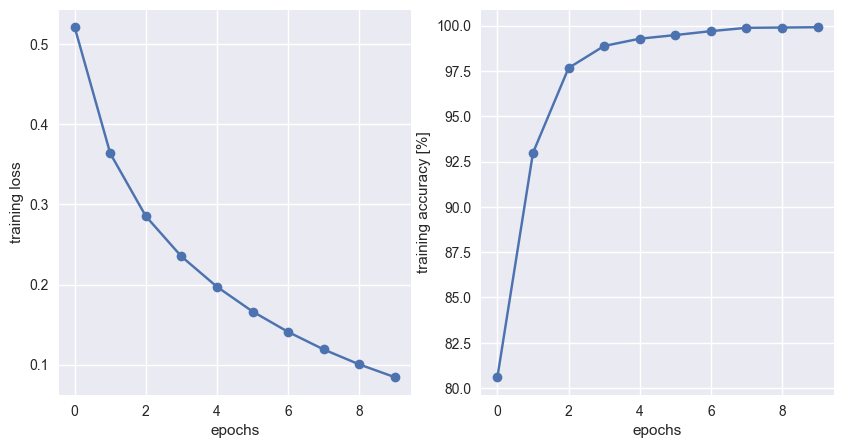

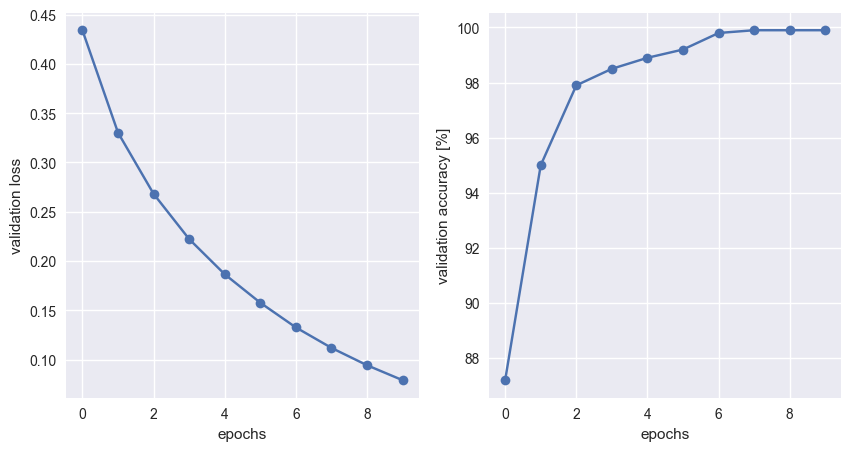

In [160]:
_,axs=plt.subplots(1,2,figsize=(10,5))
axs[0].plot(best_history.epoch,best_history.history['loss'],'o-')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('training loss')

axs[1].plot(best_history.epoch,np.array(best_history.history['accuracy'])*100,'o-')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('training accuracy [%]')

_,axs=plt.subplots(1,2,figsize=(10,5))
axs[0].plot(best_history.epoch,best_history.history['val_loss'],'o-')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('validation loss')

axs[1].plot(best_history.epoch,np.array(best_history.history['val_accuracy'])*100,'o-')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('validation accuracy [%]')

print(f"\ntest accuracy = {best}\n")
